In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

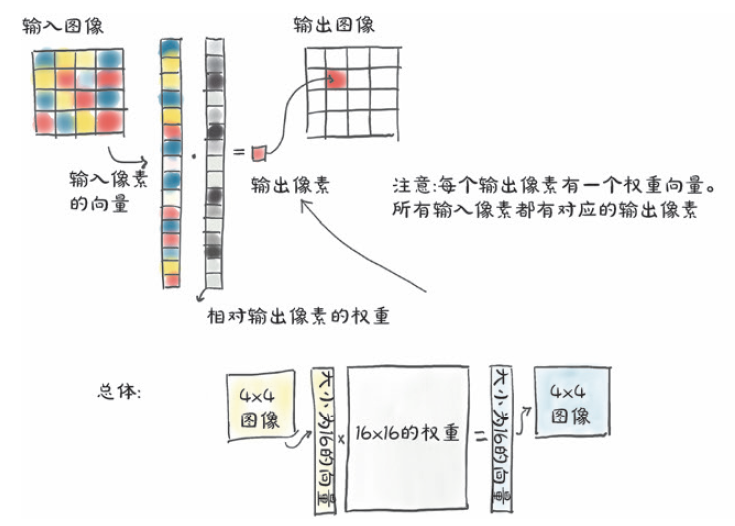


In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

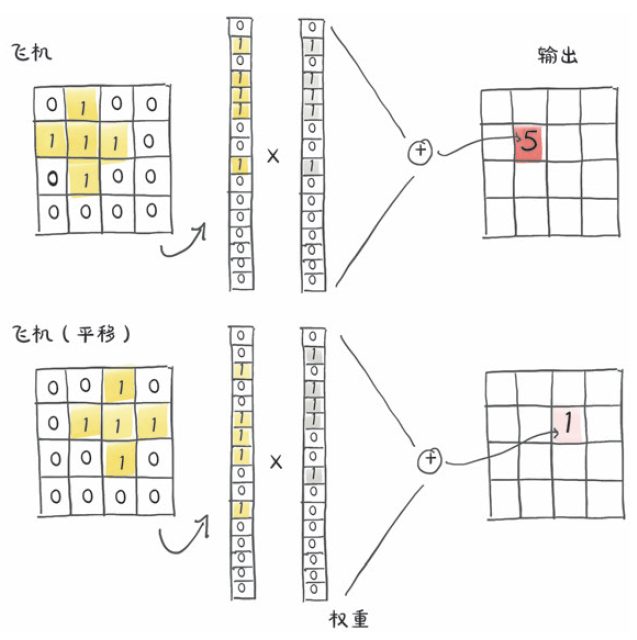

In [4]:
#处理训练集数据
from torchvision import datasets, transforms
data_path = 'D:\深度学习课件（刘）\PPT 2023春\experiment_cnn'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
# 处理测试集数据
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
# 从10类选取2类训练
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [7]:
#  利用torch定义全连接模型
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),       # 输入三个通道3*1024，隐藏层1024
            nn.Tanh(),                   # 第一隐藏层输入激活后输出
            nn.Linear(1024, 512),        # 第二隐藏层（1024，512）
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [8]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [9]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [10]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [11]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

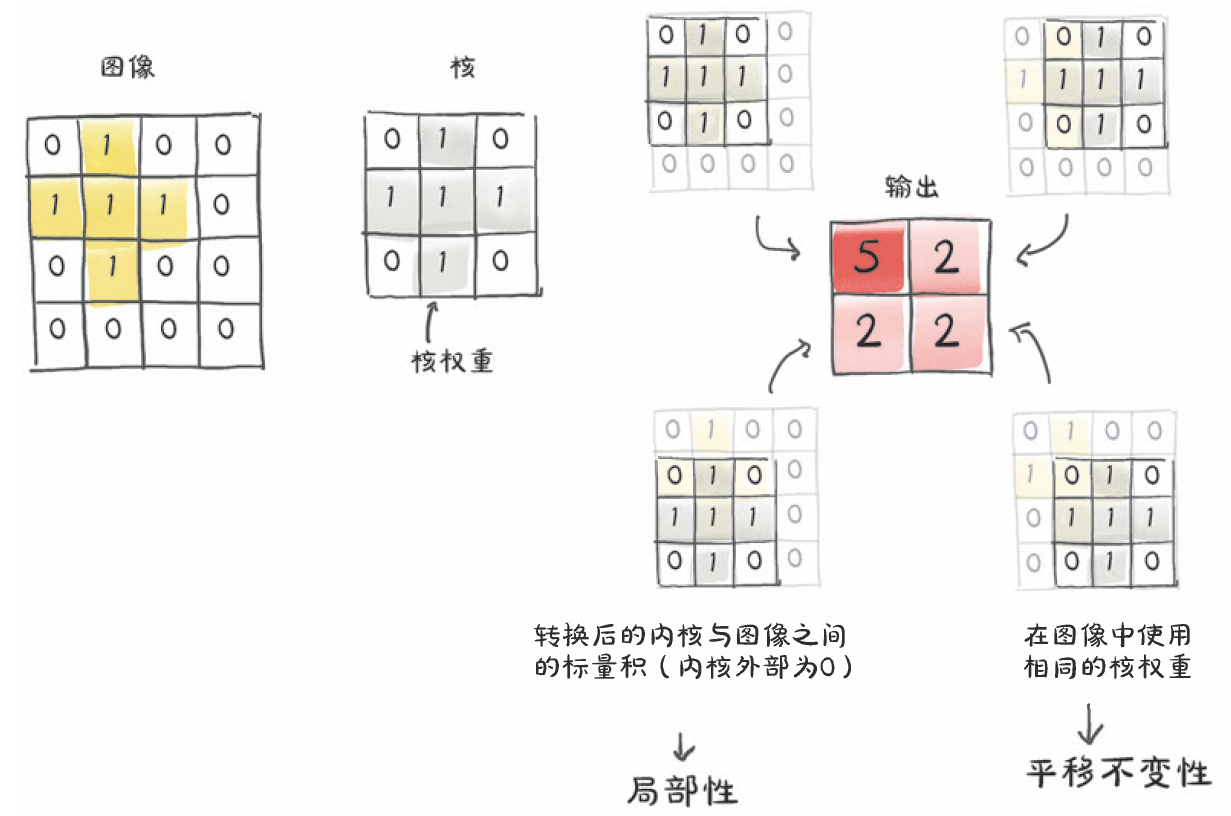

# 卷积实战
torch.nn 模块提供一维、二维、三维的卷积，其中nn.Conv1d 用于时间序列，nn.Conv2d 用于图像，nn.Conv3d 用于体数据和视频。

对于CIFAR-10 数据，我们将求助于nn.Conv2d。提供给nn.Conv2d 的参数至少包括输入特征（或通道，因为我们处理的是多通道图像，也就是说，每个像素有多个值）的数量、输出特征的数量以及核的大小等。例如，对于第1个卷积模块，每个像素有3个输入特征（RGB 通道），输出特征具有任意数量的通道数，如有16 个通道。输出图像的通道越多，表示网络的容量越大，我们借助这些通道能够检测到许多不同类型的特征。另外，由于我们是随机对它们进行初始化的，因此我们得到的一些特征，即使经过训练，也是无用的。让我们使用3×3 的卷积核。

卷积核各个方向的大小都相同是很常见的，因此PyTorch 为此提供了一个快捷方式：每当为二维卷积指定kernel_size=3 时，即3×3，Python 是以tuple(3,3)提供的。对于三维卷积，核大小为3 则表示是3×3×3。

In [16]:
conv = nn.Conv2d(3, 16, kernel_size=3)   # 与kernel_size=(3,3)等价，看输出
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [17]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

卷积核的大小为3×3，所以我们希望权重由3×3个部分组成。对于单个输出像素值，我们的卷积核考虑有in_ch=3个输入通道，因此对于单个输出像素值，其权重分量（平移整个输出通道的不变量）为in_ch×3×3。最后，我们有和输出通道一样多的通道，这里输出通道有16 个，所以完整的权重张量是out_ch×in_ch×3×3，在我们的例子中是16×3×3×3。偏置张量的大小为16。

用一个输入图像调用conv模块，我们需要通过unsqueeze()添加第0批处理维度，因为nn.Conv2d()期望输入一个B×C×H×W 的张量

In [18]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

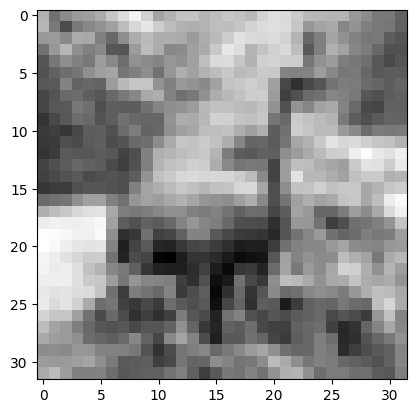

In [19]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

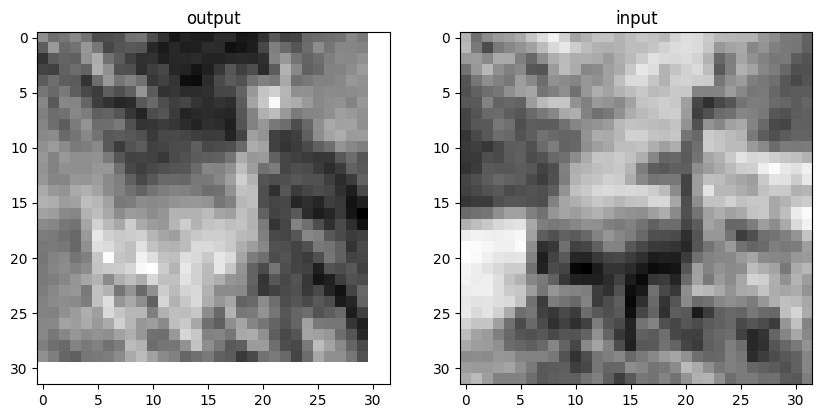

In [21]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('PyTorch.png')  # bookskip
plt.show()

## 1 填充边界

默认情况下，PyTorch 将在输入图像中滑动卷积核，得到width−kernel_width + 1个水平和垂直位置。对于奇数大小的卷积核，这将导致图像的宽度是卷积核宽度的一半（在我们的例子中，3//2 = 1），这就解释了为什么我们在每个维度上都少了2个像素。


### 零填充
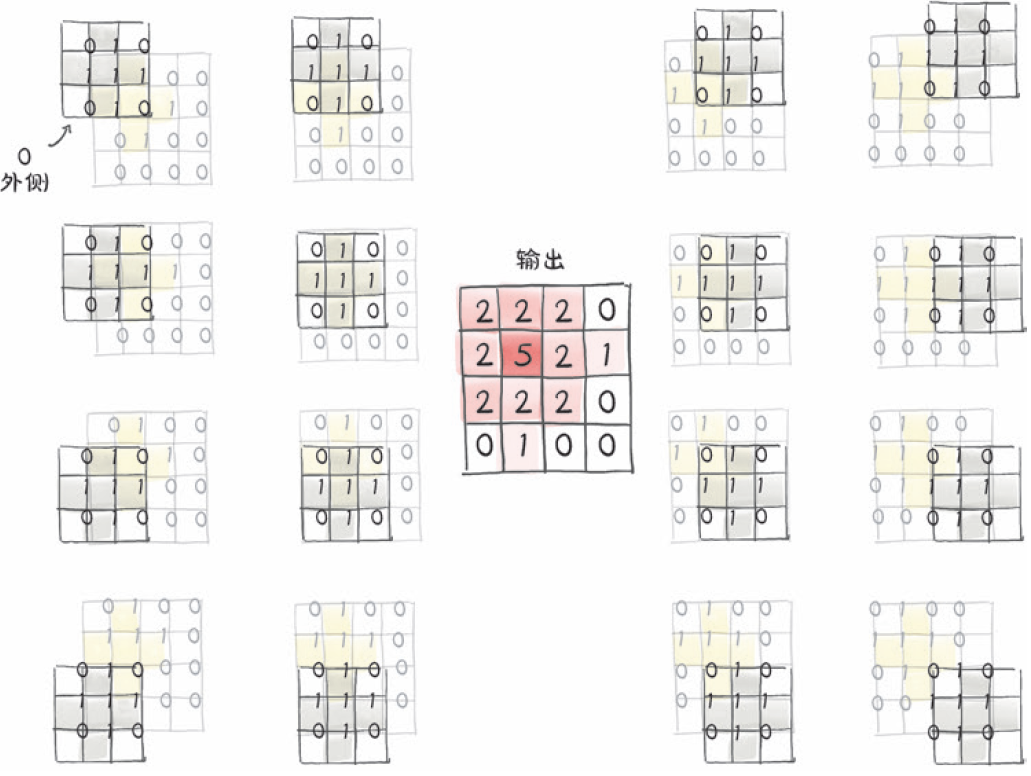

In [22]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

kernel_size=3 时指定padding=1 意味着在i00 位置的上面和左边有一组额外的领域，这样即使在原始图像的角落也可以计算出卷积的输出。最终的结果是，输出图像与输入图像的大小完全相同。

注意： 无论是否使用填充，权重和偏置的大小都不会改变。

## 2 用卷积检测特征

In [26]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

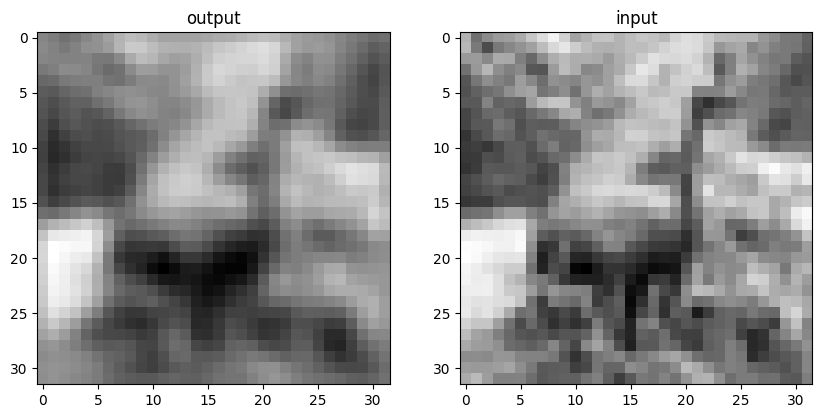

In [27]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')  #使用detach()分离tensor
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('PyTorch.png')  # bookskip
plt.show()

In [29]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()
# conv.weight边缘检测核

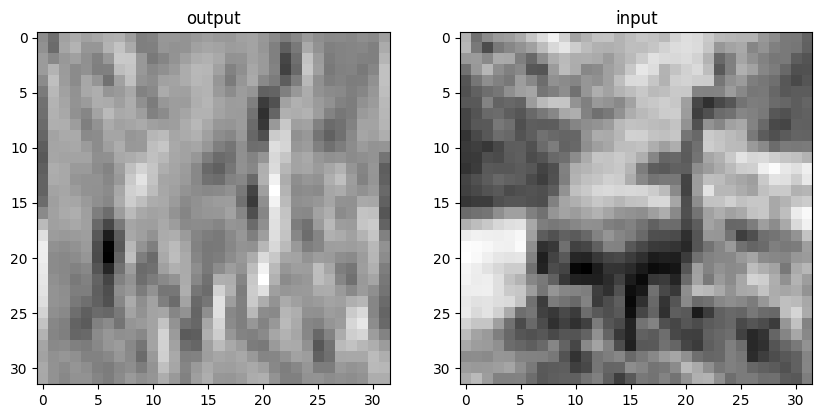

In [30]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

          卷积学习的过程：估计核权重的梯度，并分别更新它们以优化损失
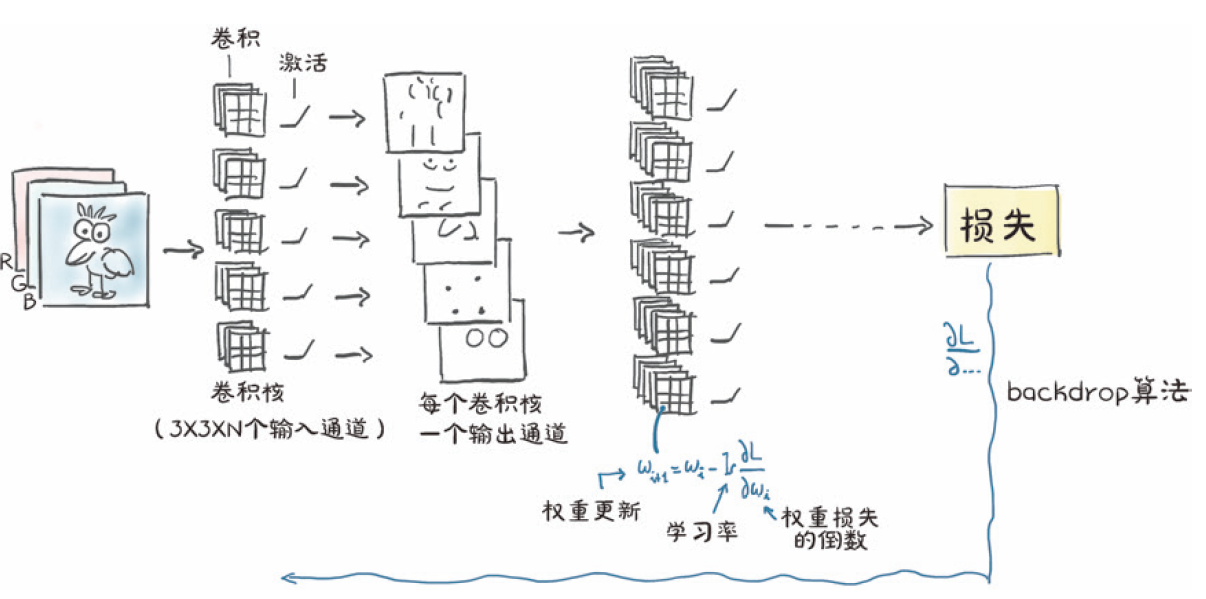

## 3 池化技术

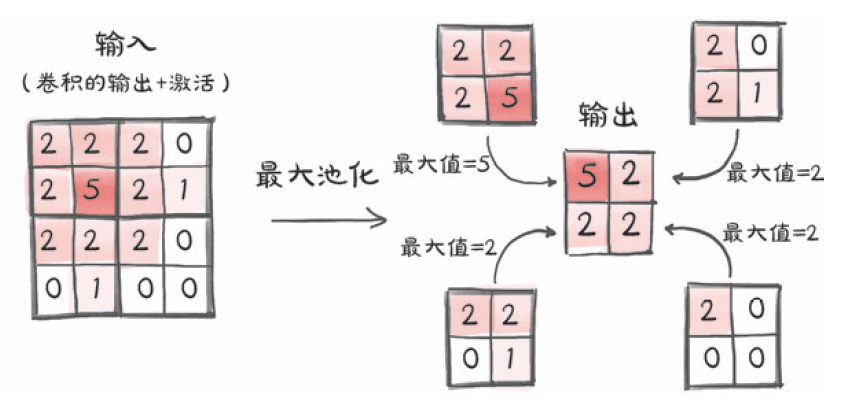

In [31]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

## 4 网络整合
以之前的全连接模型为起点，介绍nn.Conv2d 以及之前所述的nn.MaxPool2d

In [32]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

第1个卷积层将我们从3个RGB通道带到16个RGB通道，因此给网络一个机会来生成16个独立的特征，以（希望）区分鸟和飞机的低级特征。然后应用Tanh 活化函数。得到的有16个通道的、32×32 的图像被第1个MaxPool2d池化成有16个通道的、16×16的图像。在这一点上，下采样图像进行另一个卷积，产生一个有8个通道的、16×16的输出。如果幸运的话，这个输出将包含更高级的特性。同样，我们应用Tanh激活函数，然后将其池化到有8个通道的、8×8的输出。

何时结束呢？当输入图像被缩减为8×8 的特征集后，我们希望网络能够输出一些概率，我们可以将这些概率输入负对数似然中。然而，概率是一维向量中的一对数字（一个用于飞机，一个用于鸟），但这里我们仍然在处理多通道二维特征。

In [35]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>                 # 警告：少了一些重要东西
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

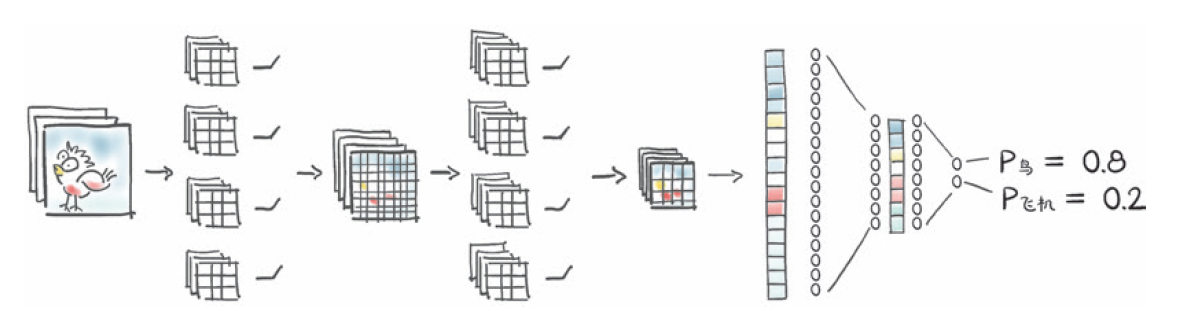

注意：线性层的大小取决于MaxPool2d 的预期输出大小：8×8×8=512。让我们计算一下这个小模型的参数数目

In [36]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [37]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

这里缺少的是从有8 个通道的、8×8 的图像转换为有512 个元素的一维向量的步骤（如果我们忽略批处理维度，则为一维向量）。这可以通过对最后一个nn.MaxPool2d()的输出调用view()来实现。但不幸的是，在使用nn.Sequential时，我们没有以任何显式可见的方式展示每个模块的输出。

# 子类化nn.Module

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)     # 在nn.sequential中缺少的重塑
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

      上面框架的模型结构
 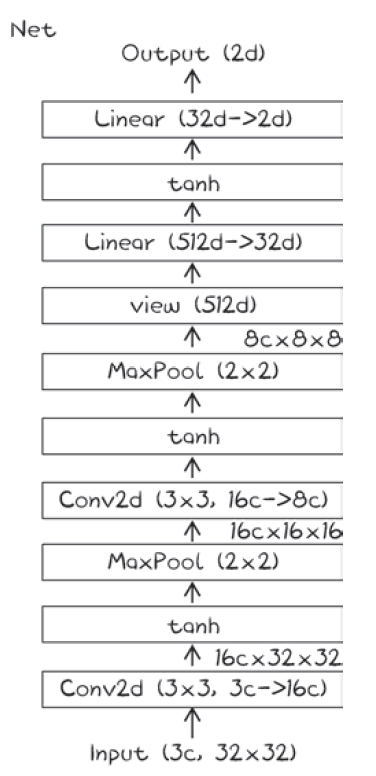
Net类相当于我们以前用子模块构建的模型nn.Sequential，但是通过显式地编写forward()方法，我们可以直接操作self.pool3 的输出，并调用view()将其转换为一个B×N 的向量。注意，我们在调
用view()时将批处理维度设置为−1，因为原则上我们不知道批次中将有多少个样本。

PyTorch跟踪参数和子模块

In [39]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

回顾一下Net类的实现，并考虑一下在构造函数中注册子模块以便访问它们参数的实用性，我们也注册没有参数的子模块似乎有点儿浪费，就像nn.Tanh 和nn.MaxPool2d。在forward()方法中直接调用这些不是更容易吗，就像我们调用view()一样？

回到模型，继续为nn.Linear 和nn.Conv2d 使用nn 模块是有意义的，因为Net能在训练期间管理它们的参数。而且我们可以安全地切换到池化和激活函数对等的方法，因为它们没有参数：

In [43]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

上代码比我们之前net代码的定义要简洁得多，并且与之完全等同。

注意：tanh这样的通用科学函数在torch.nn.functional中依然存在，但不建议使用这些入口点，而是使用顶级torch 命名空间的函数。像max_pool2d()这样的小众函数将保留在torch.nn.functional 中。

是使用函数式API 还是使用模块化API 取决于开发者编码风格和具体使用场景体验。当网络
的一部分比较简单，以至于我们想要使用nn.Sequential 时，我们使用模块化的API。当我们编写自
己的forward()方法时，对于不需要以参数形式表示状态的内容，使用函数式接口可能会更自然。

In [46]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0089,  0.0013]], grad_fn=<AddmmBackward0>)

# 训练我们的convnet

现在，我们可以组装完整的训练循环了，回想一下，convnet的核心是2个嵌套的循环：一个是跨迭代周期的外部循环，另一个是从数据集生成批次的DataLoader的内部循环。

■ 通过模型提供输入（正向传播）。
■ 计算损失（也是正向传播的一部分）。
■ 将任何老的梯度归零。
■ 调用loss.backward()来计算损失相对所有参数的梯度（反向传播）。
■ 让优化器朝着更低的损失迈进。

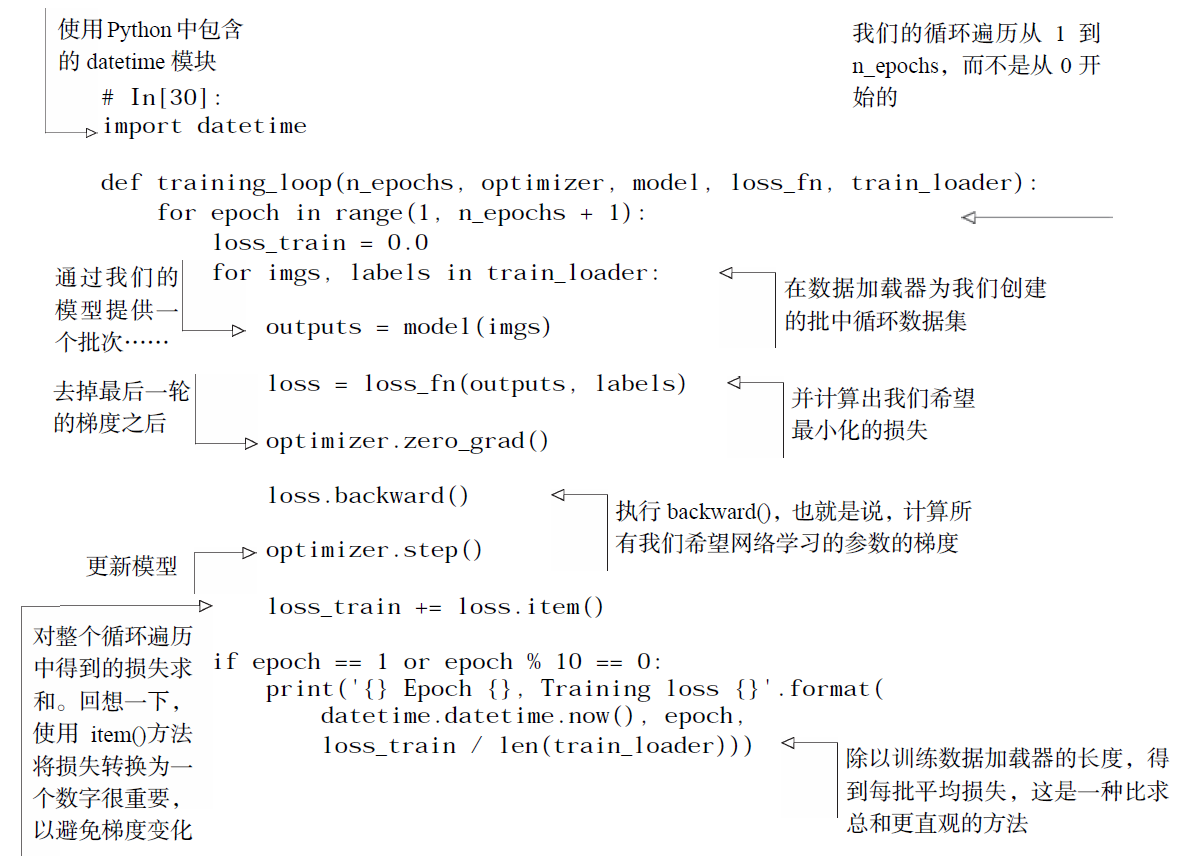

In [47]:
import datetime  #    记录训练时间
#  
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # 循环遍历从1到n_epochs，
        loss_train = 0.0
        for imgs, labels in train_loader:  #  加载批量数据
            
            outputs = model(imgs)  #   调用前面的模型，提供一个批次的输出
            
            loss = loss_fn(outputs, labels)  # 根据模型输出和标签计算损失

            optimizer.zero_grad()  #  清零上一个批次的梯度，消除梯度积累
            
            loss.backward()  #  计算我们希望网络中的参数的梯度
            
            optimizer.step()  #  更新参数  

            loss_train += loss.item()  # 计算最后一个批次中的损失和   

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # 最后一个批次的损失平均

In [52]:
# 数据加载器批量处理cifar2的样本数据集。随机打乱数据集中样本的顺序

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # 

model = Net()  #  初始化我们的模型
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  选用优化器  
loss_fn = nn.CrossEntropyLoss()    # 交叉熵损失     

training_loop(  #    调用前面定义的训练函数，打包执行方便
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-04-17 12:31:45.383380 Epoch 1, Training loss 0.5896195488370908
2023-04-17 12:31:59.206243 Epoch 10, Training loss 0.3330775509784176
2023-04-17 12:32:14.170627 Epoch 20, Training loss 0.298911706467343
2023-04-17 12:32:29.134284 Epoch 30, Training loss 0.2702097913641838
2023-04-17 12:32:43.957900 Epoch 40, Training loss 0.24868594660500812
2023-04-17 12:32:59.021897 Epoch 50, Training loss 0.2309552356126202
2023-04-17 12:33:14.428469 Epoch 60, Training loss 0.21584676486101878
2023-04-17 12:33:29.699166 Epoch 70, Training loss 0.20025495828906442
2023-04-17 12:33:44.930302 Epoch 80, Training loss 0.1838906606671157
2023-04-17 12:34:00.152661 Epoch 90, Training loss 0.16930083202043916
2023-04-17 12:34:15.299672 Epoch 100, Training loss 0.15635306608809788


## 测量精度

In [54]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # 在这里我们不需要梯度，因为我们不希望更新参数
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 最大值的索引作为输出，0或1类
                total += labels.shape[0]  #  计算样本的总数量
                correct += int((predicted == labels).sum())  #  准确率计算
                                                        #  整数张量转换为Python中的int，等价使用item()
        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.87


### 保存并加载我们的模型

In [60]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [61]:
loaded_model = Net()  #   不能改变net的结构
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

# #在GPU 上训练
nn.Module模块实现了一个将模型所有参数移动到GPU上的to()方法

In [62]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [63]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # 数据移动到cuda
            labels = labels.to(device=device) # 标签也要移动到cuda
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [65]:
# 下面的标号<1>, 将我们的模型（所有参数）移动到GPU。如果你忘记将模型或输入移动到GPU，
#你会得到张量不在同一设备上的错误，因为PyTorch 操作符不支持GPU 和CPU 的混合输入

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
# model = Net()                      # 将模型所有参数移动到GPU上，否则提示错误 
model = Net().to(device=device)  # 将模型所有参数移动到GPU上，否则提示错误 
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-04-17 14:54:35.730568 Epoch 1, Training loss 0.5686619946151782
2023-04-17 14:54:37.664541 Epoch 10, Training loss 0.3289298777747306
2023-04-17 14:54:40.198621 Epoch 20, Training loss 0.2963006911668808
2023-04-17 14:54:42.671648 Epoch 30, Training loss 0.269228018013535
2023-04-17 14:54:45.207502 Epoch 40, Training loss 0.2463444265400528
2023-04-17 14:54:47.741172 Epoch 50, Training loss 0.22545126835062246
2023-04-17 14:54:50.266993 Epoch 60, Training loss 0.20878608486834604
2023-04-17 14:54:52.792097 Epoch 70, Training loss 0.19291747470570217
2023-04-17 14:54:55.316476 Epoch 80, Training loss 0.17784381622246875
2023-04-17 14:54:57.833482 Epoch 90, Training loss 0.16619672087632167
2023-04-17 14:55:00.323341 Epoch 100, Training loss 0.15119180930363144


必须对validate()函数进行相同的修正。然后我们可以实例化我们的模型，并将其移动到
device 对应的设备上，像以前一样运行它

In [66]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [67]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

## 模型设计

改变模型参数：第1个维度是网络的宽度：每层的神经元数，或每个卷积的通道数。在PyTorch 中我们可以很容易地使模
型变宽。我们只需在第1 个卷积中指定更多的输出通道，并相应地增加后续的层数。

In [69]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [70]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2023-04-17 15:06:03.009717 Epoch 1, Training loss 0.5613318190073512
2023-04-17 15:06:05.561210 Epoch 10, Training loss 0.32096472221195316
2023-04-17 15:06:08.316495 Epoch 20, Training loss 0.2810478139265328
2023-04-17 15:06:11.049974 Epoch 30, Training loss 0.2515404677125299
2023-04-17 15:06:13.788646 Epoch 40, Training loss 0.22328492965857694
2023-04-17 15:06:16.505886 Epoch 50, Training loss 0.19692113241002818
2023-04-17 15:06:19.219532 Epoch 60, Training loss 0.17273076002005558
2023-04-17 15:06:21.978401 Epoch 70, Training loss 0.15002543175486244
2023-04-17 15:06:24.679675 Epoch 80, Training loss 0.12880810307469337
2023-04-17 15:06:27.388524 Epoch 90, Training loss 0.1090427857058443
2023-04-17 15:06:30.105362 Epoch 100, Training loss 0.09089003954153911
Accuracy train: 0.96
Accuracy val: 0.89


{'train': 0.9643, 'val': 0.8945}

避免在模型定义中硬编码数字，我们可以很容易地将一个参数传递给__init__()
并参数化宽度，同时注意在forward()方法中参数化对view()的调用：

In [72]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [73]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2023-04-17 15:07:48.184111 Epoch 1, Training loss 0.5431694716784605
2023-04-17 15:07:50.530932 Epoch 10, Training loss 0.3155240397544424
2023-04-17 15:07:53.113819 Epoch 20, Training loss 0.2760487986123486
2023-04-17 15:07:55.734983 Epoch 30, Training loss 0.24248549304190714
2023-04-17 15:07:58.490413 Epoch 40, Training loss 0.21502547606730918
2023-04-17 15:08:01.101251 Epoch 50, Training loss 0.19141699193389553
2023-04-17 15:08:03.732929 Epoch 60, Training loss 0.16935418484507092
2023-04-17 15:08:06.381351 Epoch 70, Training loss 0.14760851010585288
2023-04-17 15:08:08.771117 Epoch 80, Training loss 0.12574443676669128
2023-04-17 15:08:11.435144 Epoch 90, Training loss 0.10478790937240716
2023-04-17 15:08:13.772830 Epoch 100, Training loss 0.08591805526595207
Accuracy train: 0.97
Accuracy val: 0.89


In [74]:
sum(p.numel() for p in model.parameters())

38386

# 模型收敛和泛化：正则化

### 1 检查参数：权重惩罚

在PyTorch 中，我们可以通过在损失中添加一项来很容易地实现正则化。计算完损失后，无
论损失函数是什么，我们都可以对模型的参数进行迭代，将它们各自的平方（对于L2）或绝对
值（对于L1）相加，然后反向传播。

In [75]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()  # 对L1 正则化则使用abs()替换pow(2.0)
                          for p in model.parameters())  
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [76]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2023-04-17 15:14:18.285276 Epoch 1, Training loss 0.5954178025008766
2023-04-17 15:14:21.273103 Epoch 10, Training loss 0.3506364374403741
2023-04-17 15:14:24.565042 Epoch 20, Training loss 0.31668823141201285
2023-04-17 15:14:27.948840 Epoch 30, Training loss 0.29401259893065046
2023-04-17 15:14:31.138804 Epoch 40, Training loss 0.2746116850216677
2023-04-17 15:14:34.319136 Epoch 50, Training loss 0.2583347848930936
2023-04-17 15:14:37.995657 Epoch 60, Training loss 0.24463024787652266
2023-04-17 15:14:41.708065 Epoch 70, Training loss 0.2328631640144974
2023-04-17 15:14:45.398470 Epoch 80, Training loss 0.22258092472507696
2023-04-17 15:14:49.276710 Epoch 90, Training loss 0.21337367765083434
2023-04-17 15:14:53.055319 Epoch 100, Training loss 0.2049565413954911
Accuracy train: 0.93
Accuracy val: 0.90


###  2 Dropout
将网络每轮训练迭代中的神经元随机部分清零。Dropout 在每次迭代中有效地生成具有不同神经元拓扑的模型，使得模型中的神经元在过拟合过程中协调记忆过程的机会更少。另一种观点是，Dropout 在整个网络中干扰了模型生成的特征，产生了一种接近于增强的效果。

在PyTorch 中，我们可以通过在非线性激活与后面的线性或卷积模块之间添加一个
nn.Dropout 模块在模型中实现Dropout。作为一个参数，我们需要指定输入归零的概率。如果是
卷积，我们将使用专门的nn.Dropout2d或者nn.Dropout3d，将输入的通道归零：

In [78]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [79]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2023-04-17 15:19:38.367047 Epoch 1, Training loss 0.5721552165070917
2023-04-17 15:19:40.986298 Epoch 10, Training loss 0.3796209666379698
2023-04-17 15:19:43.899383 Epoch 20, Training loss 0.3480989931115679
2023-04-17 15:19:46.765143 Epoch 30, Training loss 0.32819993442790524
2023-04-17 15:19:49.653770 Epoch 40, Training loss 0.31448738789482483
2023-04-17 15:19:52.561965 Epoch 50, Training loss 0.2957565817673495
2023-04-17 15:19:55.437300 Epoch 60, Training loss 0.2878920494750806
2023-04-17 15:19:58.316511 Epoch 70, Training loss 0.2704624897165663
2023-04-17 15:20:01.195602 Epoch 80, Training loss 0.25861836917650927
2023-04-17 15:20:04.035842 Epoch 90, Training loss 0.2533277561710139
2023-04-17 15:20:06.960521 Epoch 100, Training loss 0.2383059634334722
Accuracy train: 0.90
Accuracy val: 0.87


###  批量归一化
批量归一化背后的主要思想是将输入重新调整到网络的激活状态，从而使小批量具有一定的理想分布。回想一下学习机制和非线性激活函数的作用，这有助于避免激活函数的输入过多地进入函数的饱和部分，从而消除梯度并减慢训练速度。

PyTorch 提供了nn.BatchNorm1d、nn.BatchNorm2d 和nn.BatchNorm3d 来实现批量归一化，使用哪种模块取决于输入的维度。由于批量归一化的目的是重新调整激活的输入，因此其位置是在线性变换在本例中是卷积）和激活函数之后，如下所示

In [82]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [81]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2023-04-17 15:24:51.331381 Epoch 1, Training loss 0.448831532791162
2023-04-17 15:24:54.546918 Epoch 10, Training loss 0.27756546124531206
2023-04-17 15:24:57.977306 Epoch 20, Training loss 0.21021147926521908
2023-04-17 15:25:01.268028 Epoch 30, Training loss 0.1601644144838403
2023-04-17 15:25:04.693391 Epoch 40, Training loss 0.11723225136661226
2023-04-17 15:25:07.960824 Epoch 50, Training loss 0.07944379659120444
2023-04-17 15:25:11.250462 Epoch 60, Training loss 0.05135141496967738
2023-04-17 15:25:14.554987 Epoch 70, Training loss 0.03382803139033591
2023-04-17 15:25:17.872126 Epoch 80, Training loss 0.021685167559819998
2023-04-17 15:25:21.095091 Epoch 90, Training loss 0.01298894059909567
2023-04-17 15:25:24.304187 Epoch 100, Training loss 0.009129369284388176
Accuracy train: 0.99
Accuracy val: 0.87


## 深入学习更复杂的结构：深度
深度允许模型处理层次信息

In [51]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [52]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2020-01-16 23:16:30.447670 Epoch 1, Training loss 0.6548013091087341
2020-01-16 23:16:35.367838 Epoch 10, Training loss 0.34000502014236084
2020-01-16 23:16:40.826647 Epoch 20, Training loss 0.30152006637138923
2020-01-16 23:16:46.217950 Epoch 30, Training loss 0.2726998861618103
2020-01-16 23:16:51.688735 Epoch 40, Training loss 0.24409755509180628
2020-01-16 23:16:57.099919 Epoch 50, Training loss 0.21648093004515218
2020-01-16 23:17:02.744809 Epoch 60, Training loss 0.19037676303629664
2020-01-16 23:17:08.267520 Epoch 70, Training loss 0.16683378478713856
2020-01-16 23:17:13.854005 Epoch 80, Training loss 0.14403212810777555
2020-01-16 23:17:19.896823 Epoch 90, Training loss 0.12033685920819355
2020-01-16 23:17:25.857992 Epoch 100, Training loss 0.09564469111668077
Accuracy train: 0.95
Accuracy val: 0.90


In [53]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2020-01-16 23:17:26.950170 Epoch 1, Training loss 0.6650038665267313
2020-01-16 23:17:32.211548 Epoch 10, Training loss 0.3292607384122861
2020-01-16 23:17:37.607961 Epoch 20, Training loss 0.2860302617595454
2020-01-16 23:17:43.125477 Epoch 30, Training loss 0.2551692724227905
2020-01-16 23:17:48.706900 Epoch 40, Training loss 0.22809805450545753
2020-01-16 23:17:54.233746 Epoch 50, Training loss 0.20181633408661862
2020-01-16 23:17:59.702800 Epoch 60, Training loss 0.17625007239781368
2020-01-16 23:18:05.151562 Epoch 70, Training loss 0.15140700171802454
2020-01-16 23:18:10.695097 Epoch 80, Training loss 0.1257421809491838
2020-01-16 23:18:16.346922 Epoch 90, Training loss 0.09920599323454177
2020-01-16 23:18:22.144790 Epoch 100, Training loss 0.07639109212786528
Accuracy train: 0.97
Accuracy val: 0.90


In [55]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [56]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    


In [57]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2020-01-16 23:18:30.438073 Epoch 1, Training loss 2.2735002310412704
2020-01-16 23:19:39.382842 Epoch 10, Training loss 0.3779076840847161
2020-01-16 23:20:55.438525 Epoch 20, Training loss 0.3001826848763569
2020-01-16 23:22:12.180387 Epoch 30, Training loss 0.24923191243296217
2020-01-16 23:23:29.717063 Epoch 40, Training loss 0.20788565244834134
2020-01-16 23:24:45.533130 Epoch 50, Training loss 0.15866709291745143
2020-01-16 23:26:01.732320 Epoch 60, Training loss 0.12134665039599321
2020-01-16 23:27:17.569136 Epoch 70, Training loss 0.08729177155787018
2020-01-16 23:28:33.241105 Epoch 80, Training loss 0.07246267570740288
2020-01-16 23:29:49.378612 Epoch 90, Training loss 0.05779321811156003
2020-01-16 23:31:05.654037 Epoch 100, Training loss 0.06602069945222917
Accuracy train: 0.97
Accuracy val: 0.86


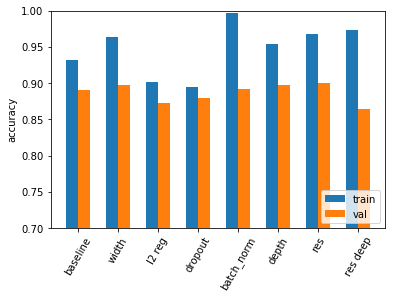

In [58]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()
